# **BASELINE MODELS**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.express as px
import scipy.stats
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve, KFold, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, auc
from sklearn.pipeline import Pipeline
from scipy.stats import sem
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from collections import Counter
from sklearn.inspection import permutation_importance
import shap
import warnings
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, silhouette_score, calinski_harabasz_score
from itertools import combinations_with_replacement
from copy import deepcopy
from sklearn.neural_network import MLPClassifier
from kneed import KneeLocator
from sklearn.cluster import KMeans
from matplotlib.pyplot import figure
from kmodes.kmodes import KModes
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster.encoder import cluster_encoder
from sklearn.metrics import pairwise_distances
from sklearn.metrics import balanced_accuracy_score
from scipy.spatial.distance import cdist
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [39]:
def log_likelihood(y_true, y_pred):
    """Calculate the log-likelihood loss between true labels and predicted labels.
    
    Args:
        y_true (numpy.ndarray): Array of true labels (0 or 1). Shape should be (n_samples,).
        y_pred (numpy.ndarray): Array of predicted probabilities for being label 1. Shape should be (n_samples,).
    
    Returns:
        float: Negative log-likelihood loss value.
    """

    # To prevent log(0)
    epsilon = 1e-7 
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    # Compute the log likelihood
    log_likelihood = y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)
    return -np.sum(log_likelihood)

In [40]:
def find_optimal_threshold(y_true, y_proba):
    """Find the optimal threshold for binary classification based on ROC curve.

    This function computes the Receiver Operating Characteristic (ROC) curve
    and then finds the threshold where the difference between True Positive Rate (TPR)
    and False Positive Rate (FPR) is maximized.

    Args:
        y_true (numpy.ndarray): Array of true labels (0 or 1). Shape should be (n_samples,).
        y_proba (numpy.ndarray): Array of predicted probabilities for being label 1. Shape should be (n_samples,).

    Returns:
        float: The optimal threshold for binary classification.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

In [41]:
def apply_smote(X_train, y_train):
    """Apply Synthetic Minority Over-sampling Technique (SMOTE) to training data.
    
    This function balances the class distribution in the training set by generating
    synthetic samples for the minority class using SMOTE.

    Args:
        X_train (numpy.ndarray or pandas.DataFrame): Training features. Shape should be (n_samples, n_features).
        y_train (numpy.ndarray or pandas.Series): Training labels. Shape should be (n_samples,).

    Returns:
        Tuple[numpy.ndarray, numpy.ndarray]: Resampled training features and labels.
        
        - X_train_res (numpy.ndarray): Resampled training features. Shape will be (n_resampled_samples, n_features).
        - y_train_res (numpy.ndarray): Resampled training labels. Shape will be (n_resampled_samples,).
    """
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

In [25]:
def create_poly_features(df, include_list=['PATIENT_AGE_AT_TREATMENT',
       'TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI'], degree=2):
    """
    Generates polynomial features with coherent names.

    Args:
        df (DataFrame): A pandas DataFrame containing the features.
        include_list (list): List of original features for which squared terms should be included.
        degree (int): The degree of the polynomial features. Default is 2.
    
    Returns:
        DataFrame: A new DataFrame with the polynomial features.
    """
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(df)

    # Generate coherent names
    poly_feature_names = []
    
    for d in range(1, degree+1):
        comb = combinations_with_replacement(df.columns, d)
        for i in list(comb):
            if len(set(i)) == 1:  # all elements in the combination are the same
                if d == 1: # no need to show power for d=1
                    poly_feature_names.append(i[0])
                else:
                    poly_feature_names.append(i[0] + "^" + str(d))
            else:
                poly_feature_names.append(" ".join(i))

    # Create a new DataFrame
    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)

    if include_list is not None:
        # List of columns to drop
        drop_columns = [col for col in poly_df.columns if "^" in col and col.split("^")[0] not in include_list]
        poly_df.drop(columns=drop_columns, inplace=True)
    
    return poly_df

In [26]:
def model_pipeline(X_train, y_train, X_test, y_test, model, metrics_list, params={},
k=10, stratified=False, AIC=False, smote=False, SHAP=False,
optimal_threshold=True, importances=False):
    """Runs a machine learning model pipeline with various options.

    This function constructs a machine learning pipeline with optional techniques such as SMOTE
    and stratified k-fold cross-validation. It trains the model, evaluates it with specified metrics,
    and can optionally calculate AIC/BIC - to be used when dealing with parametric models, feature 
    importances, SHAP values, and optimal thresholds.

    Args:
        X_train (pandas.DataFrame): Training data.
        y_train (pandas.Series): Training labels.
        X_test (pandas.DataFrame): Test data.
        y_test (pandas.Series): Test labels.
        model (object): Uninitialized machine learning model.
        metrics_list (list of str): List of metrics to evaluate. Must be keys in the 'metrics' dictionary.
        params (dict, optional): Parameters to pass to the model. Default is an empty dictionary.
        k (int, optional): Number of folds in KFold cross-validation. Default is 10.
        stratified (bool, optional): Whether to use StratifiedKFold. Default is True.
        AIC (bool, optional): Whether to compute Akaike Information Criterion. Default is False.
        smote (bool, optional): Whether to use SMOTE for oversampling. Default is False.
        SHAP (bool, optional): Whether to compute SHAP values. Default is False.
        optimal_threshold (bool, optional): Whether to find optimal threshold for classification. Default is True.
        importances (bool, optional): Whether to compute feature importances. Default is False.

    Returns:
        dict: Dictionary containing various evaluation results such as cross-validation scores,
            test scores, feature importances, and more. The specific keys depend on the input arguments.
    """
    
    # Map metric names to functions
    metrics = {
        'accuracy': balanced_accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'f1_score': f1_score,
        'auc': roc_auc_score,
        }

    # Create a pipeline with the specified model and parameters
    steps = []
    # Check if polynomial features are requested and add to the pipeline if necessary

    if smote:
        steps.append(('smote', SMOTE()))
        
    steps.append(('model', model(**params)))
    #pipeline = Pipeline(steps)
    pipeline = ImbPipeline(steps)

    # Initialize KFold cross-validation or Stratified KFold if stratified=True
    if stratified:
        cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)
    else:
        cv = KFold(n_splits=k, shuffle=True, random_state=1)

    # Compute the specified metrics using cross-validation
    cv_results = {}
    thresholds = []
    for metric in metrics_list:
        scorer = make_scorer(metrics[metric])
        cv_scores = []
        for train_index, test_index in cv.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

            pipeline.fit(X_train_fold, y_train_fold)

            if optimal_threshold and metric != 'auc':
                y_train_proba_fold = pipeline.predict_proba(X_train_fold)[:, 1]
                threshold = find_optimal_threshold(y_train_fold, y_train_proba_fold)
                thresholds.append(threshold)
            else:
                threshold = 0.5
                
            y_val_pred_proba = pipeline.predict_proba(X_val_fold)[:, 1]

            if metric == 'auc':
                cv_scores.append(scorer._score_func(y_val_fold, y_val_pred_proba))
            else:
                y_val_pred = (y_val_pred_proba >= threshold).astype(int)
                cv_scores.append(scorer._score_func(y_val_fold, y_val_pred))

        # Calculate confidence intervals
        cv_results[metric] = (np.mean(cv_scores), np.std(cv_scores))

    cv_results = pd.DataFrame(cv_results, columns=metrics_list).T
    cv_results.columns = ['Mean', 'Standard Deviation',]
    cv_results = cv_results.T

    # Compute the average optimal threshold from cross-validation
    avg_threshold = np.mean(thresholds) if thresholds else 0.5
    print('Average optimal threshold = ' + str(round(avg_threshold, 3)))

    # Fit the model on the full training set
    pipeline.fit(X_train, y_train)

    # Feature importances
    if importances:
        feature_importances = []
        for train_index, test_index in cv.split(X_train, y_train):
            X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

            pipeline.fit(X_train_fold, y_train_fold)
            fitted_model = pipeline.named_steps['model']

            if hasattr(fitted_model, 'feature_importances_'):
                fold_importance = fitted_model.feature_importances_
            elif hasattr(fitted_model, 'coef_'):
                fold_importance = np.abs(fitted_model.coef_[0])
            else:
                perm_importance = permutation_importance(fitted_model, X_test_fold, y_test_fold)
                fold_importance = perm_importance.importances_mean

            feature_importances.append(fold_importance)

        # Compute mean and standard deviation of feature importances
        feature_importances_mean = np.mean(feature_importances, axis=0)
        feature_importances_std = np.std(feature_importances, axis=0)
        
        importances_df = pd.DataFrame({
            'feature': X_train.columns,
            'importance_mean': feature_importances_mean,
            'importance_std': feature_importances_std
            })
        
        # Sort by importance_mean in descending order
        importances_df = importances_df.sort_values(by='importance_mean', ascending=False)
    
    else:
        importances_df = pd.DataFrame()

    # Compute the specified metrics on the test set
    test_results = {}
    for metric in metrics_list:
        scorer = metrics[metric]
        y_test_proba = pipeline.predict_proba(X_test)[:, 1]
        if metric == 'auc':
            test_score = scorer(y_test, y_test_proba)
        else:
            y_test_pred = (y_test_proba >= avg_threshold).astype(int)
            test_score = scorer(y_test, y_test_pred)
        test_results[metric] = test_score

    test_results = pd.DataFrame(test_results, index=['Value'], columns=metrics_list).T
    test_results = test_results.T

    # Compute the confusion matrix on the test set
    conf_matrix = confusion_matrix(y_test, y_test_pred) 

    # Output mean and std of cross-validation scores and test set scores
    output = {
        'cv_results': cv_results,
        'test_results': test_results,
        'y_test_pred': y_test_pred,
        'y_test_proba': y_test_proba, 
    }

    if AIC:
        y_pred_train_prob = pipeline.predict_proba(X_train)[:, 1] # Get predicted probabilities for the positive class
        n = X_train.shape[0] # Number of observations
        k = len(pipeline.named_steps['model'].coef_[0]) + 1 # Number of parameters in the model, adding 1 for intercept
        logL = log_likelihood(y_train, y_pred_train_prob)
        aic = 2 * k - 2 * logL
        bic = np.log(n) * k - 2 * logL
        output['aic'] = aic
        print('AIC: '+str(round(aic, 3)))
        output['bic'] = bic
        print('BIC: '+str(round(bic, 3)))

    output['feature_importances'] = importances_df

    # Print CV results
    print('')
    print('CV RESULTS')
    display(cv_results)
    print('')

    #Print Test results
    print('TEST RESULTS')
    display(test_results)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Live Birth', 'Live Birth'])
    disp.plot(cmap="Greens",  colorbar=False)
    plt.title('Test Set Confusion Matrix')
    plt.grid(False)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', bbox_inches='tight', dpi=600)
    plt.show()
    print('')

    #Print Features analysis
    if importances:
        print('FEATURES ANALYSIS')
        display(importances_df.head(20))

    if SHAP:
        # Compute SHAP values
        if hasattr(pipeline.named_steps['model'], 'feature_importances_'):
            explainer = shap.TreeExplainer(pipeline.named_steps['model'])
            shap_values = explainer.shap_values(X_train)

            # Create a SHAP summary plot
            shap.summary_plot(shap_values, X_train, plot_size=[20,10], max_display=20)

        elif hasattr(pipeline.named_steps['model'], 'coef_'):
            explainer = shap.LinearExplainer(pipeline.named_steps['model'], X_train)
            shap_values = explainer.shap_values(X_train)

            # Create a SHAP summary plot
            shap.summary_plot(shap_values, X_train, plot_size=[20,10], max_display=20)

    return output

## **0. Data**

In [27]:
TRAIN = pd.read_parquet('TRAIN_2016.parquet')
TEST = pd.read_parquet('TEST_2016.parquet')

In [28]:
# Separate the targets from the data
y_train_live_birth = TRAIN['LIVE_BIRTH_OCCURRENCE']
y_test_live_birth = TEST['LIVE_BIRTH_OCCURRENCE']

X_train = TRAIN.drop(['FRESH_EGGS_COLLECTED', 'TOTAL_EMBRYOS_CREATED', 'LIVE_BIRTH_OCCURRENCE'], axis=1)
X_test = TEST.drop(['FRESH_EGGS_COLLECTED', 'TOTAL_EMBRYOS_CREATED', 'LIVE_BIRTH_OCCURRENCE'], axis=1)

## **I. Live Birth Occurence Baseline**

### **I. 1. Default Baseline Candidates**

In [47]:
# Performance of the Void Zeros model
y_void_pred = np.zeros_like(y_test_live_birth)
void_accuracy = accuracy_score(y_test_live_birth, y_void_pred)
void_precision = precision_score(y_test_live_birth, y_void_pred)
void_recall = recall_score(y_test_live_birth, y_void_pred)
void_f1_score = f1_score(y_test_live_birth, y_void_pred)
void_auc = roc_auc_score(y_test_live_birth, y_void_pred)
print("Void Zeros Accuracy:", void_accuracy)
print("Void Zeros Precision:", void_precision)
print("Void Zeros Recall:", void_recall)
print("Void Zeros F1 Score:", void_f1_score)
print("Void Zeros AUC:", void_auc)
print('')

y_void_pred = np.ones_like(y_test_live_birth)
void_accuracy = accuracy_score(y_test_live_birth, y_void_pred)
void_precision = precision_score(y_test_live_birth, y_void_pred)
void_recall = recall_score(y_test_live_birth, y_void_pred)
void_f1_score = f1_score(y_test_live_birth, y_void_pred)
void_auc = roc_auc_score(y_test_live_birth, y_void_pred)
print("Void Ones Accuracy:", void_accuracy)
print("Void Ones Precision:", void_precision)
print("Void Ones Recall:", void_recall)
print("Void Ones F1 Score:", void_f1_score)
print("Void Ones AUC:", void_auc)

Void Zeros Accuracy: 0.7303250386950827
Void Zeros Precision: 0.0
Void Zeros Recall: 0.0
Void Zeros F1 Score: 0.0
Void Zeros AUC: 0.5

Void Ones Accuracy: 0.26967496130491725
Void Ones Precision: 0.26967496130491725
Void Ones Recall: 1.0
Void Ones F1 Score: 0.4247936984246062
Void Ones AUC: 0.5


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


## Simple Logistic Regression

Average optimal threshold = 0.462
AIC: -44163.194
BIC: -44053.706

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.606946,0.336908,0.782601,0.470977,0.642457
Standard Deviation,0.005473,0.004414,0.013846,0.004486,0.008640



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.610674,0.340062,0.781015,0.473818,0.634979


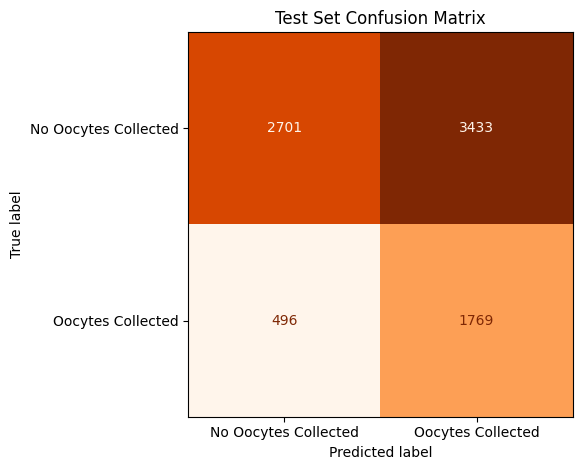

In [65]:
# Simple Logistic Regression with OPTIMAL THRESHOLD
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'max_iter':1000, 'random_state': 42, 'class_weight': 'balanced'}
results_LR = model_pipeline(X_train, y_train_live_birth, X_test, y_test_live_birth, model, metrics_list, params, 
k=10, stratified=True, AIC=True, smote=False, SHAP=False, optimal_threshold=True)

In [14]:
with open('probas_LR.txt', 'w') as f:
    for item in results_LR['y_test_proba']:
        f.write("%s\n" % item)

## Squared Logistic Regression

Average optimal threshold = 0.494
AIC: -43682.466
BIC: -42916.052

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.612462,0.345704,0.747378,0.472652,0.646947
Standard Deviation,0.008316,0.006984,0.014854,0.006984,0.008780



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.612363,0.346656,0.739073,0.471948,0.63649


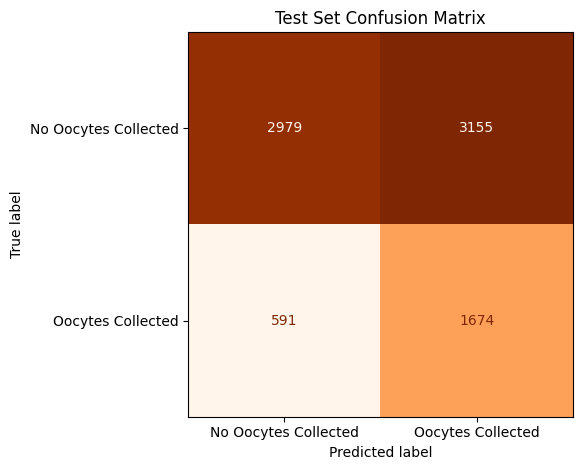

In [66]:
# Squared Logistic Regression with OPTIMAL THRESHOLD
X_train_poly = create_poly_features(X_train)
X_test_poly = create_poly_features(X_test)
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'max_iter':1000, 'random_state': 42, 'class_weight': 'balanced'}
results_LR2 = model_pipeline(X_train_poly, y_train_live_birth, X_test_poly, y_test_live_birth, model, metrics_list, params, 
k=10, stratified=True, AIC=True, smote=False, SHAP=False, optimal_threshold=True)

In [16]:
with open('probas_LR2.txt', 'w') as f:
    for item in results_LR2['y_test_proba']:
        f.write("%s\n" % item)

Average optimal threshold = 0.498
AIC: -43718.168
BIC: -42951.754

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.612486,0.346865,0.736558,0.471278,0.645634
Standard Deviation,0.008410,0.006773,0.011193,0.006688,0.008439



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.612363,0.346656,0.739073,0.471948,0.638326


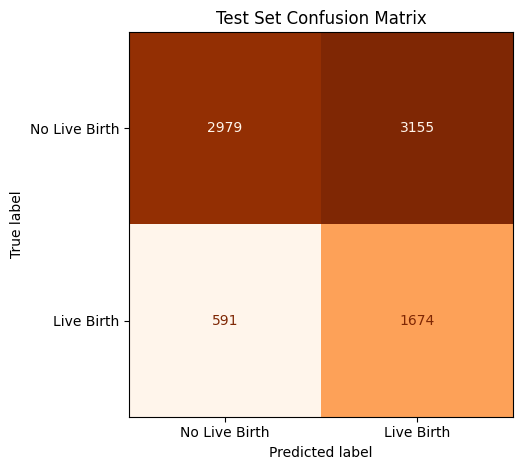

In [14]:
# Squared Logistic Regression with SMOTE
X_train_poly = create_poly_features(X_train)
X_test_poly = create_poly_features(X_test)
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'max_iter':1000, 'random_state': 42, 'class_weight': 'balanced'}
results_LR2 = model_pipeline(X_train_poly, y_train_live_birth, X_test_poly, y_test_live_birth, model, metrics_list, params, 
k=10, stratified=True, AIC=True, smote=True, SHAP=False, optimal_threshold=True)

## Cubic Logistic Regression

Average optimal threshold = 0.485
AIC: -42699.261
BIC: -38867.19

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.610361,0.344086,0.744726,0.470654,0.644033
Standard Deviation,0.007501,0.004930,0.017910,0.007275,0.009593



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.612248,0.346672,0.73819,0.471783,0.634066


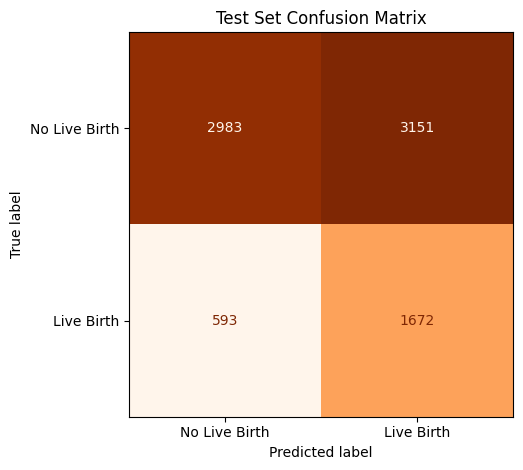

In [48]:
# Cubic Logistic Regression
X_train_poly = create_poly_features(X_train, degree=3)
X_test_poly = create_poly_features(X_test, degree=3)
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'max_iter':4000, 'random_state': 42, 'class_weight': 'balanced', 'n_jobs':-1}
results_LR3 = model_pipeline(X_train_poly, y_train_live_birth, X_test_poly, y_test_live_birth, model, metrics_list, params, 
k=10, stratified=True, AIC=True, smote=False, SHAP=False, optimal_threshold=True)

In [19]:
with open('probas_LR3.txt', 'w') as f:
    for item in results_LR3['y_test_proba']:
        f.write("%s\n" % item)

## Decision Tree

Average optimal threshold = 0.502

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.599557,0.338955,0.711056,0.459015,0.619881
Standard Deviation,0.005217,0.003960,0.015255,0.004996,0.007819



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.601397,0.341385,0.705077,0.460032,0.620891


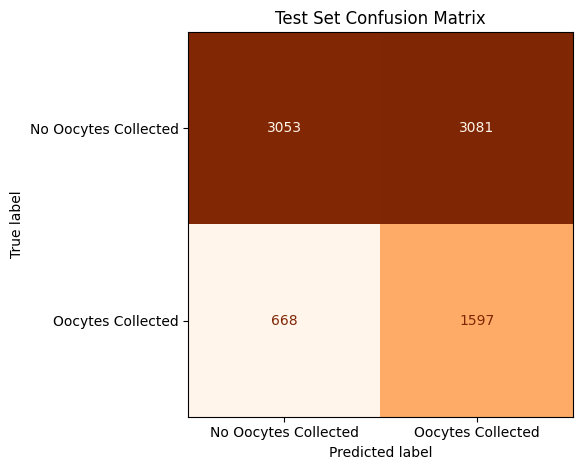

In [69]:
# Decision Tree
model = DecisionTreeClassifier
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'random_state': 42, 'class_weight': 'balanced'}
results_DT = model_pipeline(X_train, y_train_live_birth, X_test, y_test_live_birth, model, metrics_list, params, 
k=10, stratified=True, AIC=False, smote=False, SHAP=False, optimal_threshold=True)

In [ ]:
with open('probas_DT.txt', 'w') as f:
    for item in results_DT['y_test_proba']:
        f.write("%s\n" % item)

## Random Forest

Average optimal threshold = 0.478

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.603404,0.341253,0.719890,0.462966,0.625725
Standard Deviation,0.006627,0.005287,0.013505,0.005917,0.008843



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.605391,0.343578,0.715673,0.46427,0.625939


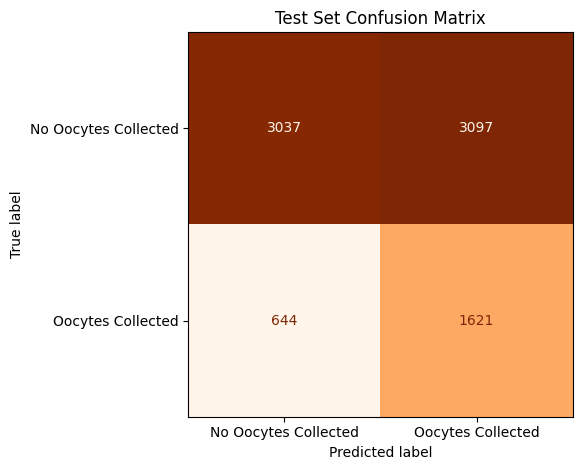

In [70]:
# Random Forest
model = RandomForestClassifier
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'random_state': 42, 'class_weight': 'balanced', 'n_estimators': 100}
results_RF = model_pipeline(X_train, y_train_live_birth, X_test, y_test_live_birth, model, metrics_list, params, 
k=10, stratified=True, AIC=False, smote=False, SHAP=False, optimal_threshold=True)

In [ ]:
with open('probas_RF.txt', 'w') as f:
    for item in results_RF['y_test_proba']:
        f.write("%s\n" % item)

## XGBoost

Average optimal threshold = 0.502

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.606047,0.344624,0.711279,0.464188,0.635721
Standard Deviation,0.006590,0.003198,0.025634,0.007512,0.007727



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.606516,0.346836,0.699338,0.4637,0.632579


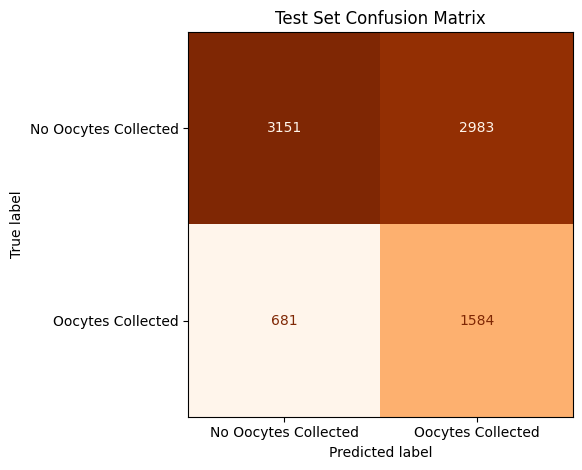

In [71]:
# XGBoost
counter = Counter(y_train_live_birth)
estimate = counter[0] / counter[1]
model = XGBClassifier
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'random_state': 42, 'scale_pos_weight': estimate}
results_XGB = model_pipeline(X_train, y_train_live_birth, X_test, y_test_live_birth, model, metrics_list, params, 
k=10, stratified=True, AIC=False, smote=False, SHAP=False, optimal_threshold=True)

In [ ]:
with open('probas_XGB.txt', 'w') as f:
    for item in results_XGB['y_test_proba']:
        f.write("%s\n" % item)

## Multilayer Perceptron

Average optimal threshold = 0.272

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.610205,0.346075,0.729051,0.469249,0.645987
Standard Deviation,0.005350,0.004512,0.019649,0.005276,0.007668



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.608041,0.346693,0.710375,0.465972,0.63694


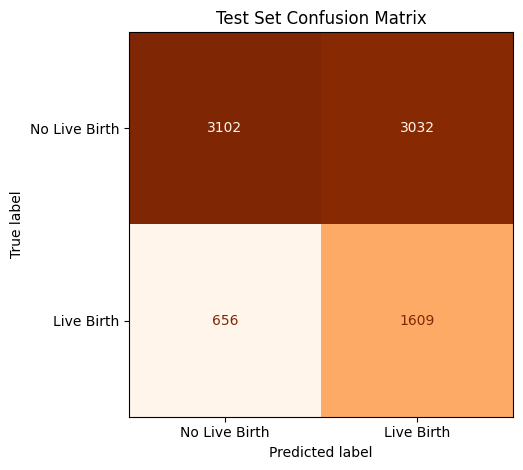

In [73]:
# Multilayer Perceptron
model = MLPClassifier
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'random_state': 42, 'max_iter': 1000}
results_MLP = model_pipeline(X_train, y_train_live_birth, X_test, y_test_live_birth, model, metrics_list, params, 
k=10, stratified=True, AIC=False, smote=False, SHAP=False, optimal_threshold=True)

In [ ]:
with open('probas_MLP.txt', 'w') as f:
    for item in results_MLP['y_test_proba']:
        f.write("%s\n" % item)

# II. Clustering Exploration

### II. 1. Building the clustering algorithms

In [74]:
def find_optimal_k(X_train, min_clusters, max_clusters, display=True):
    """
    Find the optimal number of clusters (k) for given training data using k-means clustering.
    
    The function evaluates clustering performance using the Sum of Squared Errors (SSE), Silhouette Coefficient, 
    and Calinski-Harabasz Index. The optimal k is determined using the "elbow" method, and the corresponding 
    clustering model is returned.

    Args:
        X_train (DataFrame): The training data for clustering.
        min_clusters (int): The minimum number of clusters to consider.
        max_clusters (int): The maximum number of clusters to consider.
        display (bool, optional): If True, plots the Elbow plot for k selection and displays performance metrics. Defaults to True.

    Returns:
        tuple: 
            - optimal_k (int): The optimal number of clusters determined.
            - best_model (model object): The best clustering model fitted with optimal_k.
            - X_train_with_cluster (DataFrame): Training data with an additional 'cluster' column indicating the cluster each sample belongs to.
    """
    
    sse = {}
    sil_coefs = {}
    ch_scores = {}
    best_model = None
    optimal_k = None
    
    for k in tqdm(range(min_clusters, max_clusters), desc="Processing clusters"):
        model = KMeans(n_clusters=k, random_state=0, n_init=10)
        pred = model.fit_predict(X_train)
        sse[k] = model.inertia_
        sil_coefs[k] = silhouette_score(X_train, pred)
        ch_scores[k] = calinski_harabasz_score(X_train, pred)
    
    kn = KneeLocator(x=list(sse.keys()), y=list(sse.values()), 
                 curve='convex', 
                 direction='decreasing')

    optimal_k = kn.knee
    print('Optimal K is '+str(optimal_k))
    if optimal_k:
        best_model = KMeans(n_clusters=optimal_k, random_state=0)
        pred = best_model.fit_predict(X_train)
        X_train_with_cluster = X_train.copy()
        X_train_with_cluster['cluster'] = pred


        if display:
            figure(figsize=(14, 10), dpi=600)
            plt.title('Elbow plot for K selection', fontsize=16)
            plt.xlabel('k')
            plt.ylabel('SSE')
            sns.pointplot(x=list(sse.keys()),
                y=list(sse.values()),
                color=colours_gaia[0])
            plt.axvline(x=optimal_k-min_clusters, color=colours_gaia[1], linestyle='dashed')
            plt.savefig('elbow_plot.png', dpi=600)
            plt.show()
        
            print(f"Silhouette Coefficient for optimal k ({optimal_k}): {sil_coefs[optimal_k]}")
            print(f"Calinski-Harabasz Index for optimal k ({optimal_k}): {ch_scores[optimal_k]}")

    return optimal_k, best_model, X_train_with_cluster

Processing clusters: 100%|██████████| 29/29 [03:25<00:00,  7.10s/it]
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Optimal K is 10


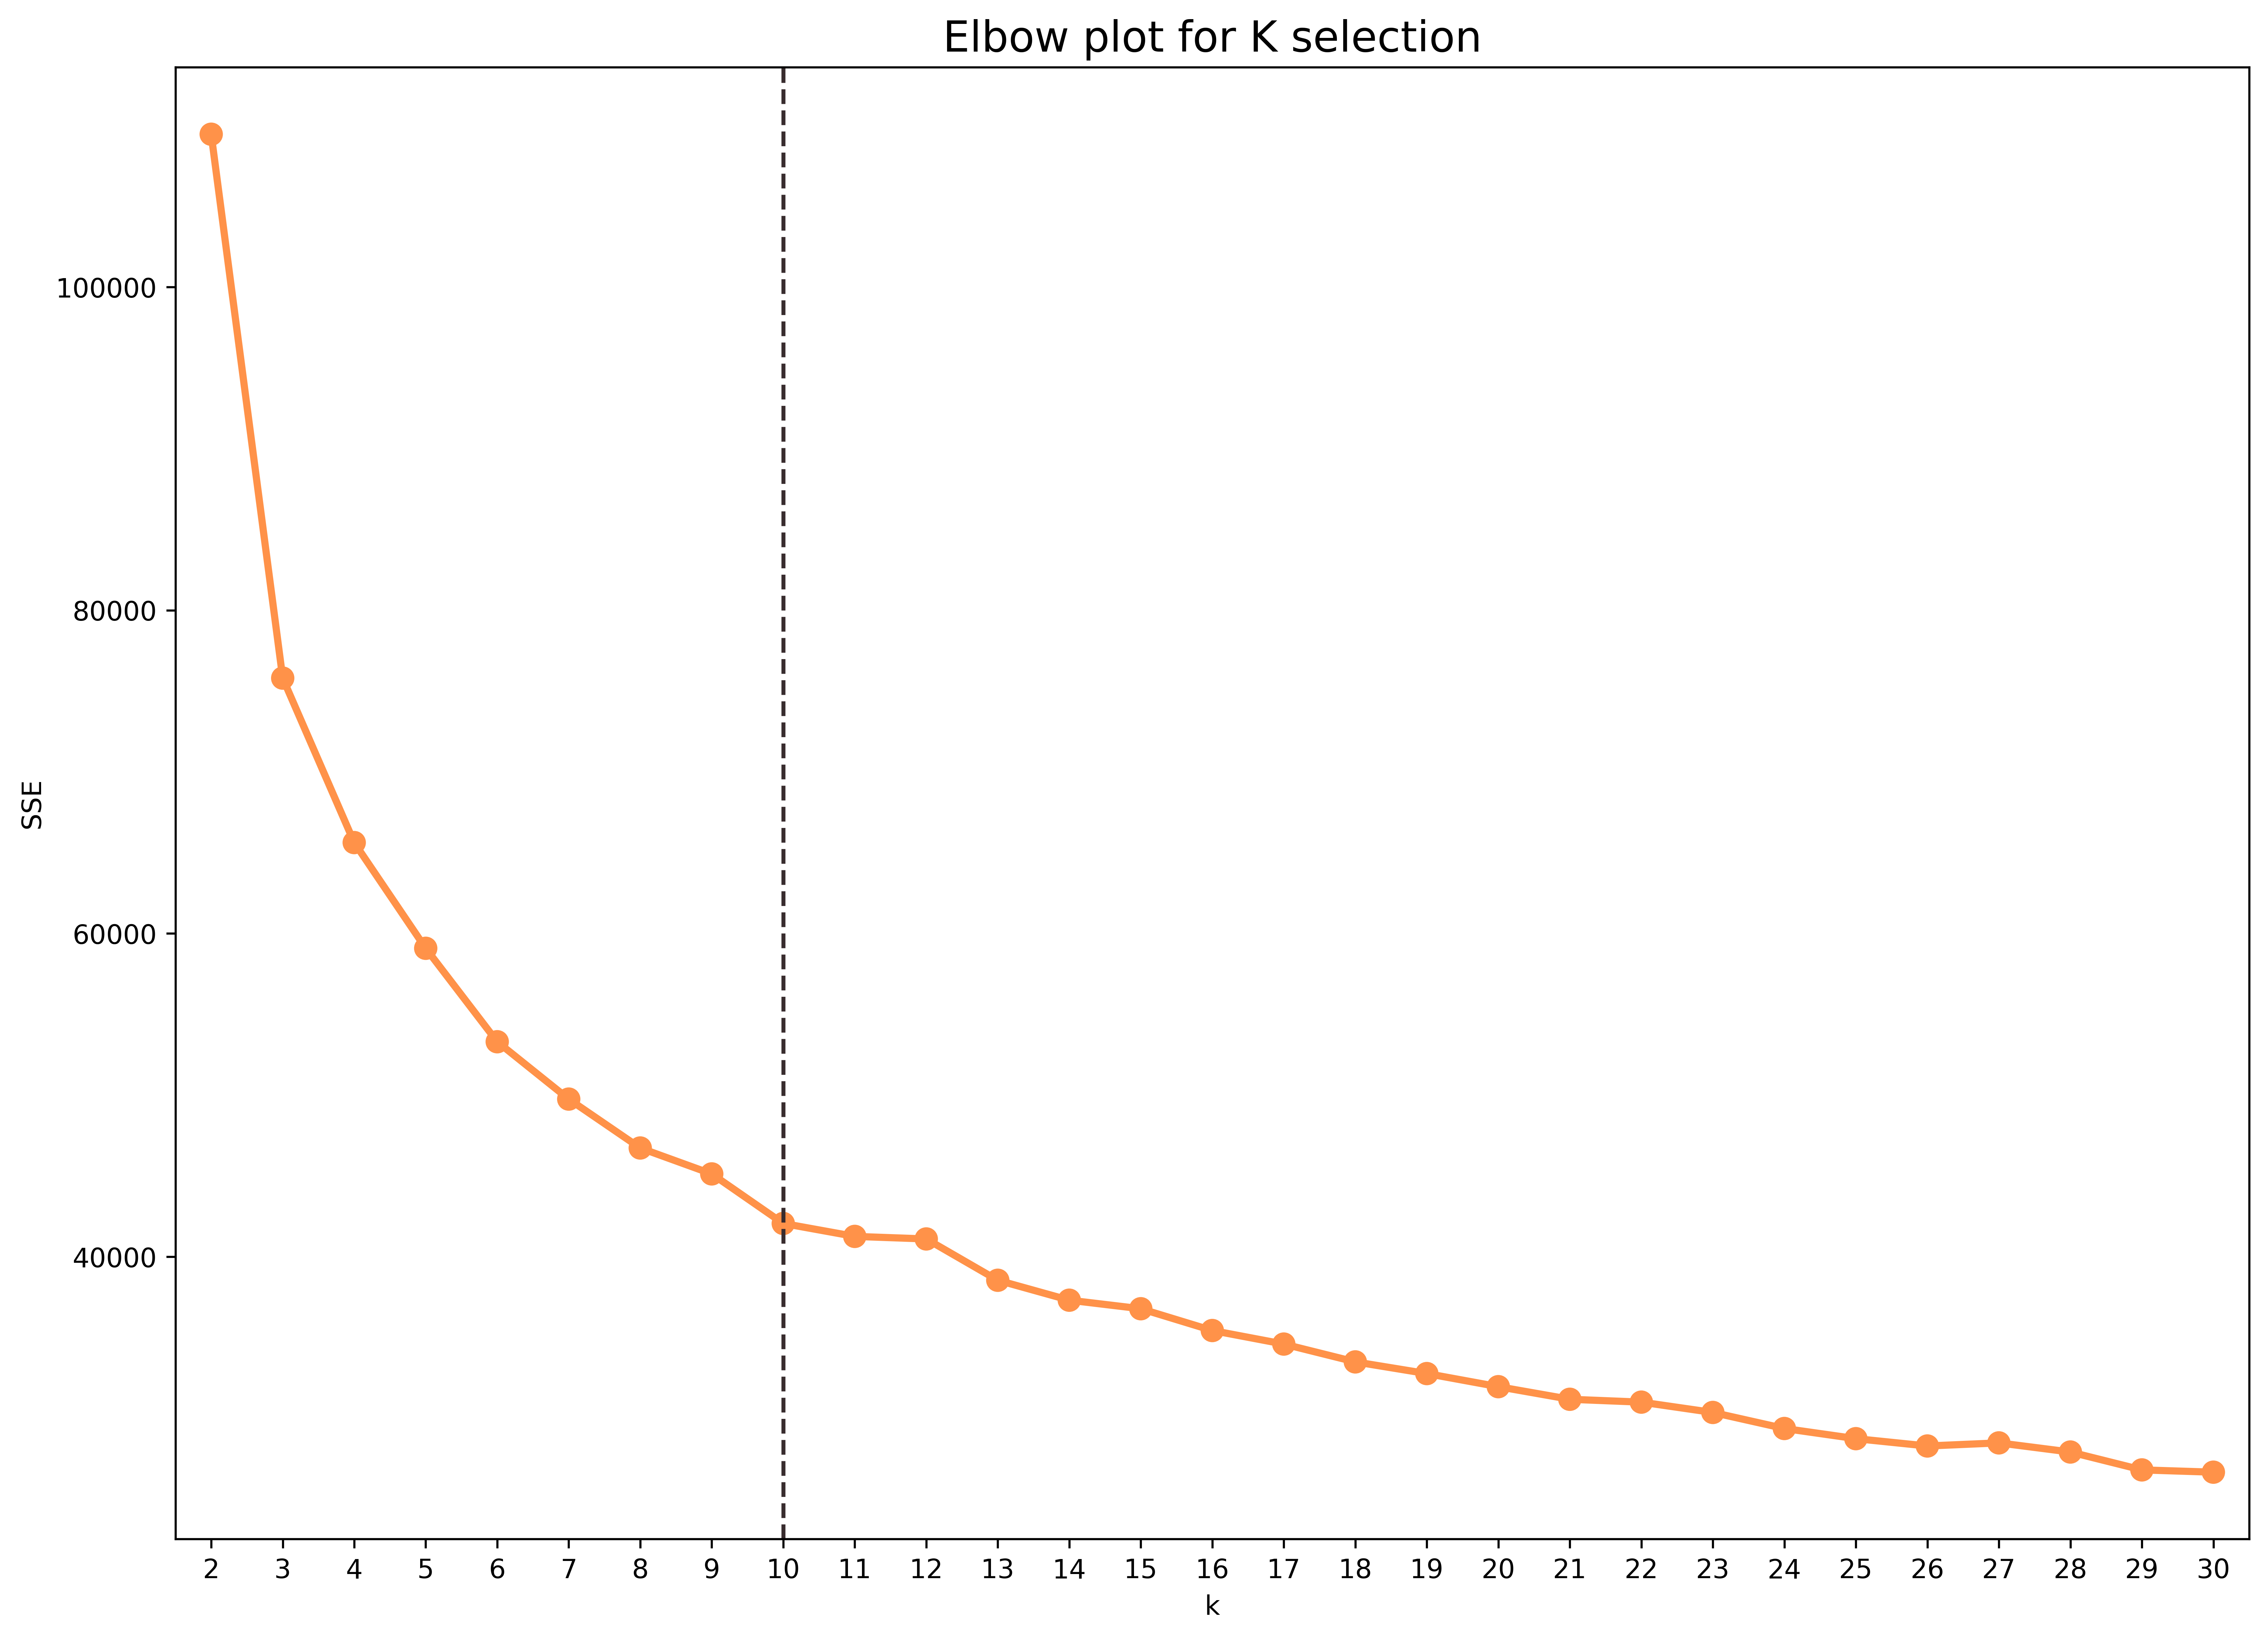

Silhouette Coefficient for optimal k (10): 0.2641908250400584
Calinski-Harabasz Index for optimal k (10): 10773.459356552692


In [75]:
optimal_k, best_model, X_train_with_cluster = find_optimal_k(X_train, min_clusters=2, max_clusters=31, display=True)

In [76]:
X_train_with_cluster['cluster'].value_counts()

2    5372
5    5251
8    4551
4    4442
0    3756
1    3162
9    2293
3    2273
7    1384
6    1111
Name: cluster, dtype: int64

In [77]:
X_train_with_cluster['LIVE_BIRTH_OCCURRENCE'] = y_train_live_birth
mean_binary_feature = X_train_with_cluster.groupby('cluster')['LIVE_BIRTH_OCCURRENCE'].mean()
print(mean_binary_feature)

cluster
0    0.268104
1    0.324794
2    0.349404
3    0.087989
4    0.176722
5    0.350981
6    0.303330
7    0.137283
8    0.318172
9    0.149586
Name: LIVE_BIRTH_OCCURRENCE, dtype: float64


## II. 2. Dividing the model by clusters

In [78]:
def split_dataframe(df, group_column, y_column):
    """
    Split a DataFrame based on a specified grouping column and separately store a given column's values.

    For each unique value in the grouping column, the function creates a new DataFrame containing all rows
    with that value, and then drops the grouping column and another specified column from this new DataFrame.
    The values from the dropped column for each group are stored in a separate dictionary.

    Args:
        df (pd.DataFrame): The DataFrame to be split.
        group_column (str): The name of the column on which the DataFrame should be grouped.
        y_column (str): The name of the column whose values should be saved separately.

    Returns:
        tuple: 
            - dfs (dict of pd.DataFrame): Dictionary where keys are unique values from the 'group_column' and values are the corresponding split DataFrames.
            - saved_columns (dict): Dictionary where keys are unique values from the 'group_column' and values are the corresponding values from the 'y_column'.
    """
    
    dfs = {}
    saved_columns = {}
    for name, group in df.groupby(group_column):
        saved_columns[name] = group[y_column]
        group = group.drop([group_column, y_column], axis=1)  # drop the 'group_column' and 'column_to_drop'
        dfs[name] = group
    return dfs, saved_columns

In [83]:
def clustered_predictions(X_train, y_train, X_test, y_test, cluster_model):
    """
    Performs model fitting and evaluation applying the Cascade #1 method, using kmeans in combination with Logistic Regression.

    The function first predicts cluster assignments for both train and test data. Then, for each cluster, a Logistic 
    Regression model is trained on the training set of that cluster. Predictions are made on the test data belonging 
    to the same cluster. Overall performance metrics are then calculated by combining predictions across all clusters.

    Args:
        X_train (pd.DataFrame): The training feature set.
        y_train (pd.Series or ndarray): The training target set.
        X_test (pd.DataFrame): The test feature set.
        y_test (pd.Series or ndarray): The test target set.
        cluster_model (model object): Pre-trained clustering model (like KMeans) used to predict cluster assignments.

    Returns:
        tuple:
            - y_test_pred (ndarray): Predicted target values for the test set.
            - y_test_true (ndarray): True target values for the test set.
            - y_test_probas (ndarray): Predicted probabilities for the positive class for the test set.

    Notes:
        - This function makes use of `split_dataframe` to divide data based on cluster assignments. Ensure that 
          this function is defined and available in your code.
        - The function utilizes Logistic Regression for predictions, using a model pipeline that appears to be 
          custom-defined elsewhere (`model_pipeline`). Ensure that this function is available and appropriately defined.
        - Metrics such as accuracy, precision, recall, etc., are computed using sklearn's metric functions.
        - Requires libraries: numpy (as np), tqdm, sklearn.metrics, and matplotlib.pyplot (as plt).
        - Display of the confusion matrix makes use of the `ConfusionMatrixDisplay` class from sklearn.
    """
    
    # Build the train sets
    X_test_with_cluster = cluster_model.predict(X_train)
    X_train_clustered = X_train.copy()
    X_train_clustered['cluster'] = X_test_with_cluster
    X_train_clustered['LIVE_BIRTH_OCCURRENCE'] = y_train
    X_trains, y_trains = split_dataframe(X_train_clustered, group_column='cluster', y_column='LIVE_BIRTH_OCCURRENCE')

    # Build the test sets
    X_test_with_cluster = cluster_model.predict(X_test)
    X_test_clustered = X_test.copy()
    X_test_clustered['cluster'] = X_test_with_cluster
    X_test_clustered['LIVE_BIRTH_OCCURRENCE'] = y_test
    X_tests, y_tests = split_dataframe(X_test_clustered, group_column='cluster', y_column='LIVE_BIRTH_OCCURRENCE')

    # For loop to run models over all of these and extract y_preds
    y_test_pred = np.array([])
    y_test_true = np.array([])
    y_test_probas = np.array([])

    for i in tqdm(range(len(X_trains)), desc="Training cluster level models:"):
        # Squared Logistic Regression with OPTIMAL THRESHOLD
        model = LogisticRegression
        metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
        params = {'max_iter':2000, 'random_state': 42, 'class_weight': 'balanced'}
        results = model_pipeline(X_trains[i], y_trains[i], X_tests[i], y_tests[i], model, metrics_list, params, 
        k=10, stratified=True, AIC=False, smote=False, SHAP=False, optimal_threshold=True, importances=False)

        y_test_pred = np.concatenate([y_test_pred, results['y_test_pred']])
        y_test_true = np.concatenate([y_test_true, y_tests[i]])
        y_test_probas = np.concatenate([y_test_probas, results['y_test_proba']])

    print('')
    print('')
    print('Combined results:')
    accuracy = balanced_accuracy_score(y_test_true, y_test_pred)
    precision = precision_score(y_test_true, y_test_pred)
    recall = recall_score(y_test_true, y_test_pred)
    f1 = f1_score(y_test_true, y_test_pred)
    auc = roc_auc_score(y_test_true, y_test_pred)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("AUC:", auc)
    print('')

    conf_matrix = confusion_matrix(y_test_true, y_test_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Live Birth', 'Live Birth'])
    disp.plot(cmap="Oranges")
    plt.title('Test confusion matrix')
    plt.grid(False)
    plt.tight_layout()
    plt.show()


    return y_test_pred, y_test_true, y_test_probas

Training cluster level models::   0%|          | 0/10 [00:00<?, ?it/s]

Average optimal threshold = 0.473

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.569760,0.313834,0.697168,0.432636,0.579197
Standard Deviation,0.023472,0.014703,0.053113,0.023404,0.032549



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.568616,0.330882,0.708661,0.451128,0.56387


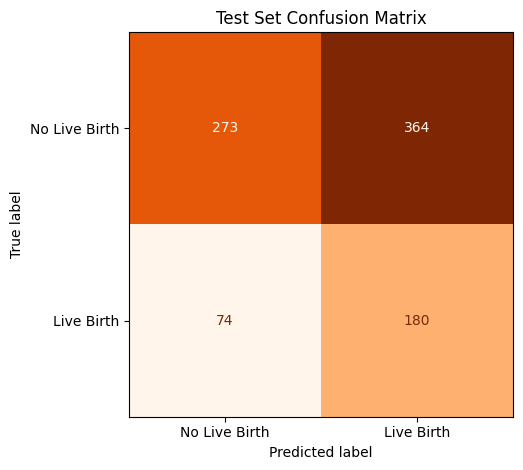

Training cluster level models::  10%|█         | 1/10 [00:01<00:13,  1.54s/it]


Average optimal threshold = 0.511

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.542322,0.368938,0.477137,0.415461,0.562866
Standard Deviation,0.020237,0.021959,0.047038,0.028646,0.028789



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.512295,0.328571,0.445736,0.378289,0.529469


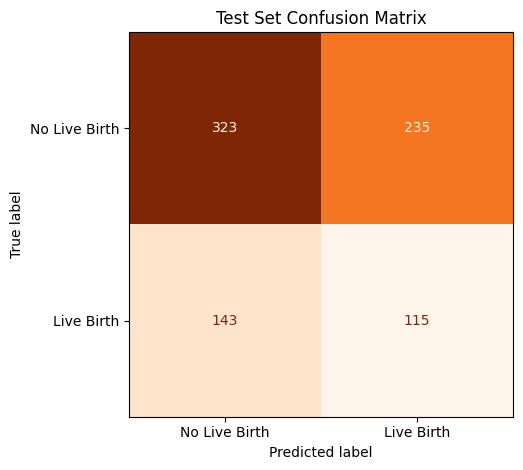

Training cluster level models::  20%|██        | 2/10 [00:03<00:13,  1.74s/it]


Average optimal threshold = 0.501

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.537048,0.376739,0.663801,0.480543,0.545639
Standard Deviation,0.015278,0.011221,0.031593,0.015974,0.022462



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.514348,0.33865,0.66506,0.44878,0.512843


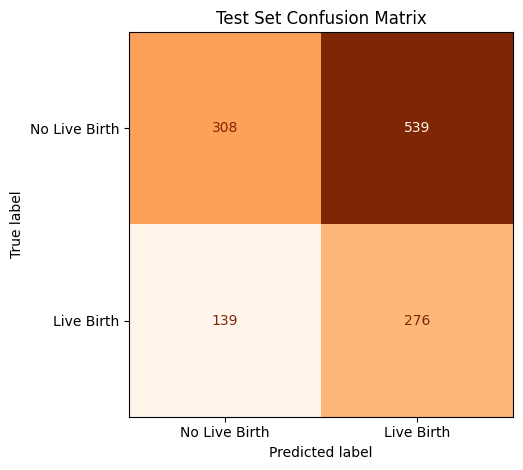

Training cluster level models::  30%|███       | 3/10 [00:05<00:13,  1.98s/it]


Average optimal threshold = 0.495

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.643957,0.137254,0.74000,0.231202,0.654087
Standard Deviation,0.026090,0.011723,0.05831,0.017194,0.028063



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.690917,0.125424,0.840909,0.218289,0.67832


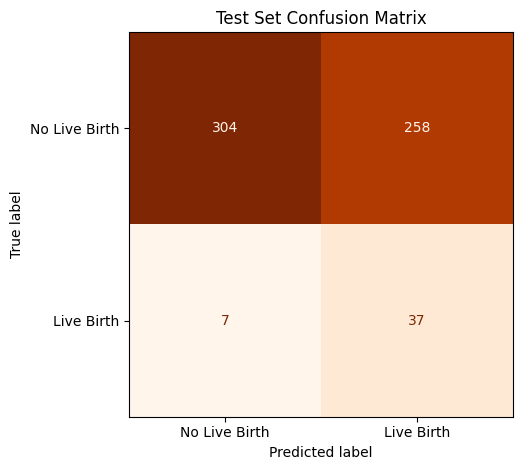

Training cluster level models::  40%|████      | 4/10 [00:07<00:10,  1.75s/it]


Average optimal threshold = 0.496

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.550937,0.206322,0.602548,0.306475,0.566321
Standard Deviation,0.019869,0.015409,0.056551,0.017928,0.022102



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.548501,0.195876,0.590674,0.294194,0.568943


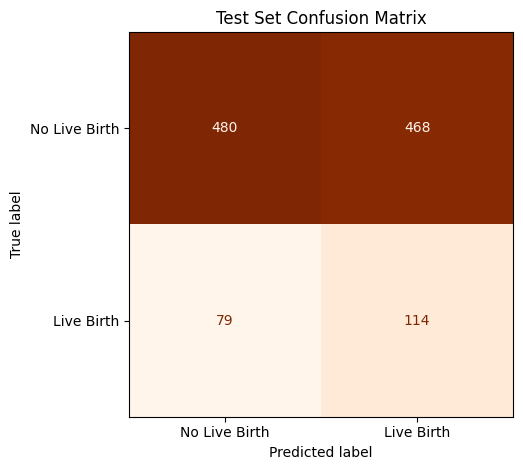

Training cluster level models::  50%|█████     | 5/10 [00:08<00:08,  1.74s/it]


Average optimal threshold = 0.494

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.531902,0.370778,0.774800,0.501262,0.548820
Standard Deviation,0.019844,0.012369,0.048086,0.018916,0.032416



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.524895,0.381663,0.764957,0.509246,0.536741


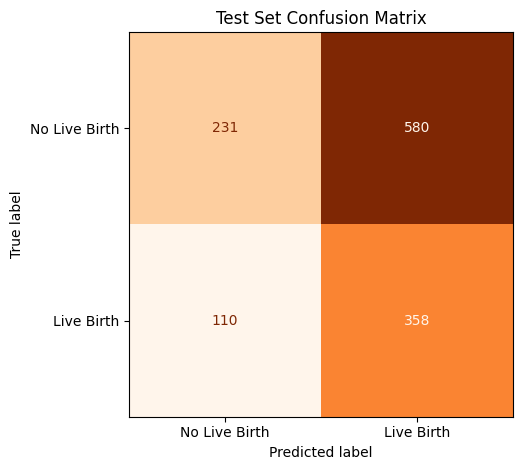

Training cluster level models::  60%|██████    | 6/10 [00:10<00:07,  1.87s/it]


Average optimal threshold = 0.523

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.565421,0.385413,0.454902,0.410224,0.581726
Standard Deviation,0.045580,0.058622,0.109713,0.059996,0.048859



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.472944,0.330508,0.382353,0.354545,0.508233


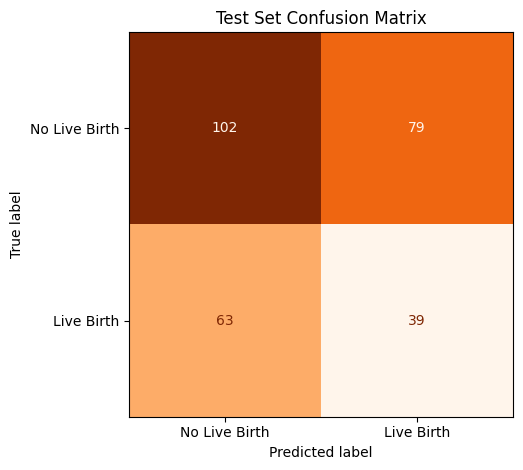

Training cluster level models::  70%|███████   | 7/10 [00:12<00:05,  1.69s/it]


Average optimal threshold = 0.5

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.576238,0.184538,0.578947,0.277339,0.632328
Standard Deviation,0.048245,0.036035,0.070613,0.041615,0.039915



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.661813,0.25,0.730769,0.372549,0.693235


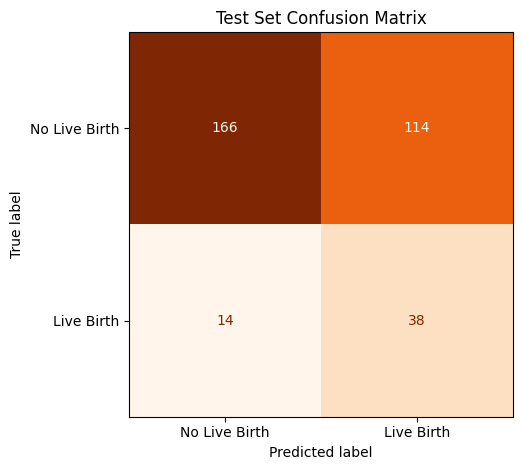

Training cluster level models::  80%|████████  | 8/10 [00:13<00:03,  1.56s/it]


Average optimal threshold = 0.505

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.556129,0.359686,0.663012,0.466153,0.574142
Standard Deviation,0.015366,0.010957,0.035820,0.016147,0.023211



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.545033,0.354934,0.637566,0.456008,0.554487


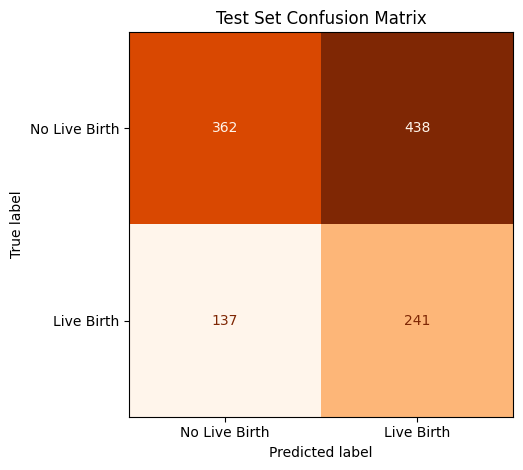

Training cluster level models::  90%|█████████ | 9/10 [00:14<00:01,  1.52s/it]


Average optimal threshold = 0.486

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.583191,0.191550,0.656639,0.295862,0.618983
Standard Deviation,0.058511,0.027176,0.110067,0.041447,0.063478



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.621239,0.228395,0.732673,0.348235,0.650815


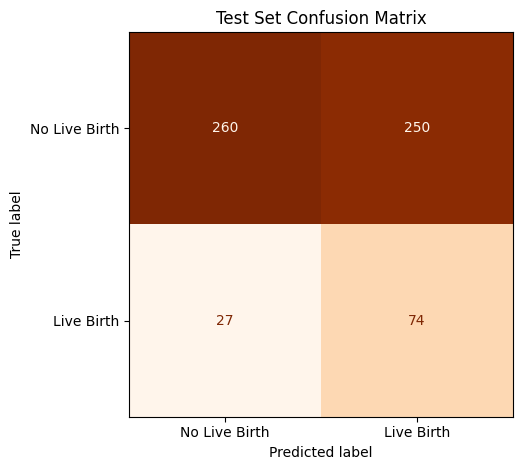

Training cluster level models:: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]




Combined results:
Accuracy: 0.55391448957103
Precision: 0.3068584531999166
Recall: 0.6498896247240619
F1 Score: 0.41687907108467853
AUC: 0.55391448957103



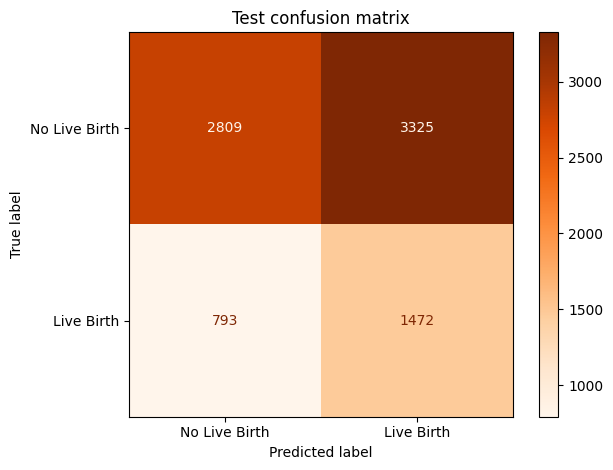

In [84]:
y_test_pred, y_test_true, y_test_probas = clustered_predictions(X_train, y_train_live_birth, X_test, y_test_live_birth, cluster_model=best_model)

In [ ]:
with open('probas_C_DC_LR.txt', 'w') as f:
    for item in y_test_probas:
        f.write("%s\n" % item)

## II. 3. Clustering for feature engineering

In [31]:
def find_optimal_k(X_train, min_clusters, max_clusters):
    """
    Determine the optimal number of clusters (k) for given training data using the k-means clustering method.
    
    The function evaluates clustering performance using the Sum of Squared Errors (SSE) and determines the optimal k 
    using the "elbow" method.

    Args:
        X_train (pd.DataFrame or ndarray): The training data for clustering.
        min_clusters (int): The minimum number of clusters to consider.
        max_clusters (int): The maximum number of clusters to consider.

    Returns:
        int: The optimal number of clusters (k). If no optimal k is found, it returns 0.
    """
    
    sse = {}
    for k in range(min_clusters, max_clusters):
        kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
        kmeans.fit(X_train)
        sse[k] = kmeans.inertia_
    
    kn = KneeLocator(x=list(sse.keys()), y=list(sse.values()), 
                 curve='convex', 
                 direction='decreasing')

    k = kn.knee

    if k == None:
        k = 0
        
    return k

In [32]:
def clustering_model(X_train, optimal_k):
    """
    Train a KMeans clustering model using the specified number of clusters (optimal_k).
    
    Args:
        X_train (pd.DataFrame or ndarray): The training data for clustering.
        optimal_k (int): The optimal number of clusters to use in the KMeans clustering model.

    Returns:
        KMeans: A trained KMeans clustering model.
    """
    kmeans = KMeans(n_clusters=optimal_k, random_state=0, n_init=10)
    kmeans.fit(X_train)
    return kmeans

In [33]:
def centers(kmeans):
    """
    Extract cluster centers from a trained KMeans clustering model.

    Args:
        kmeans (KMeans): A trained KMeans clustering model.

    Returns:
        pd.DataFrame: A DataFrame containing the cluster centers.
    """
    centers = pd.DataFrame(kmeans.cluster_centers_)
    return centers

In [34]:
def distances(X, centers):
    """
    Compute the Euclidean distances of each data point in X to each of the provided cluster centers.

    For each cluster center, the function computes the Euclidean distance between that center and 
    each data point in the dataset `X`, and then stores these distances in a new DataFrame.

    Args:
        X (pd.DataFrame or ndarray): Data for which the distances are to be calculated.
        centers (pd.DataFrame): A DataFrame containing cluster centers.

    Returns:
        pd.DataFrame: A DataFrame where each column corresponds to a cluster center and each row 
        contains the distances of data points in `X` to that cluster center. Columns are named 
        'Cluster_0', 'Cluster_1', ... based on the order of cluster centers in the `centers` DataFrame.
    """

    distances_df = pd.DataFrame() 
    for j in range(len(centers)):
        distances = []

        for i in range(len(X)):
            dist_row = np.linalg.norm(np.array(X.iloc[i])-np.array(centers.iloc[j]))
            distances.append(dist_row)
          
        col_name = 'Cluster_'+str(j)
        distances_df[col_name] = distances

    return distances_df

In [35]:
class KMeansTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, min_clusters=2, max_clusters=30, display=False):
        self.min_clusters = min_clusters
        self.max_clusters = max_clusters
        self.display = display
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        """
        Fit the model by determining the optimal number of clusters, training a KMeans model, and computing cluster distance features.
        
        This method carries out the following steps:
        1. Finds the optimal number of clusters using the `find_optimal_k` method.
        2. Trains a KMeans clustering model on the data.
        3. Extracts cluster centers using the `centers` function.
        4. Computes distances of each data point to cluster centers.
        5. Fits the scaler on these distances.
        6. Creates new feature names for the distance features.

        Args:
            X (pd.DataFrame or ndarray): The input data to fit on.
            y (Optional[ndarray]): Target values. Not used in this method but kept for compatibility with scikit-learn's API.

        Returns:
            self: Returns the instance of the model.
        """
        
        self.optimal_k = find_optimal_k(X, self.min_clusters, self.max_clusters, self.display)
        self.kmeans_model = clustering_model(X, self.optimal_k)
        self.cluster_centers = centers(self.kmeans_model)

        # Compute the cluster distance features
        X_distances = distances(X, self.cluster_centers)

        # Fit the scaler
        self.scaler.fit(X_distances)

        # Create new feature names for the distance features
        self.new_feature_names = [f"dist_{i}" for i in range(X_distances.shape[1])]
        
        return self

    def transform(self, X, y=None):
        """
        Transform the input data by computing cluster distance features and standardizing them.
        
        This method performs the following steps:
        1. Computes distances of each data point in `X` to the cluster centers.
        2. Standardizes these distance features using the fitted scaler.
        3. Appends these distance features to the original dataset `X`.

        Args:
            X (pd.DataFrame or ndarray): The input data to be transformed.
            y (Optional[ndarray]): Target values. Not used in this method but kept for compatibility with scikit-learn's API.

        Returns:
            None: The function updates the instance's attributes in place but does not return any value.
        """
        
        X_distances = distances(X, self.cluster_centers)

        # Standardize the cluster distance features
        X_distances = self.scaler.transform(X_distances)

        # Name the new columns
        X_distances = pd.DataFrame(X_distances, columns=self.new_feature_names)
        X = pd.concat([X.reset_index().drop(columns='index'), X_distances], axis=1, join="inner")

        feature_names = X.columns

        return X


In [36]:
def model_pipeline_augmented(X_train, y_train, X_test, y_test, model, metrics_list, params={},
k=10, stratified=True, AIC=False, smote=False, SHAP=False,
optimal_threshold=True, importances=False):
    """Runs an advanced machine learning model pipeline for a two-stage classifier, leveraging unsupervised learning in the first stage.

    This function constructs a machine learning pipeline with optional feature augmentation using
    KMeansTransformer, alongside other techniques such as SMOTE for handling class imbalance.
    It evaluates the model's performance on training data using either KFold or StratifiedKFold 
    cross-validation based on the 'stratified' argument, and evaluates the performance on a test set.
    Furthermore, this function can optionally calculate AIC/BIC for parametric models, determine
    feature importances, generate SHAP values for interpretability, and compute an optimal threshold 
    for classification tasks.

    Args:
        X_train (pandas.DataFrame): Training data features.
        y_train (pandas.Series): Training data labels.
        X_test (pandas.DataFrame): Test data features.
        y_test (pandas.Series): Test data labels.
        model (object): Model class to be initialized.
        metrics_list (list of str): Metrics for evaluation. Must be valid keys in the 'metrics' dictionary.
        params (dict, optional): Dictionary of model hyperparameters. Default is an empty dictionary.
        k (int, optional): Number of splits for cross-validation. Default is 10.
        stratified (bool, optional): If True, use StratifiedKFold, else use KFold. Default is True.
        AIC (bool, optional): If True, compute Akaike Information Criterion. Relevant for parametric models. Default is False.
        smote (bool, optional): If True, use SMOTE for handling class imbalance. Default is False.
        SHAP (bool, optional): If True, compute SHAP values for model interpretability. Default is False.
        optimal_threshold (bool, optional): If True, compute optimal threshold for classification. Default is True.
        importances (bool, optional): If True, compute and evaluate feature importances. Default is False.

    Returns:
        dict: Contains various evaluation results. This may include cross-validation scores, 
            performance metrics on the test set, predicted values for the test set, feature importances, 
            and more. The specific content of this dictionary varies based on the provided input arguments.
    """

    
    # Map metric names to functions
    metrics = {
        'accuracy': balanced_accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'f1_score': f1_score,
        'auc': roc_auc_score,
        }

    # Create a pipeline with the specified model and parameters
    steps = []

    # Transformer four unsupervised feature augmentation
    steps.append(('kmeans_transform', KMeansTransformer()))

    if smote:
        steps.append(('smote', SMOTE()))
        
    steps.append(('model', model(**params)))
    pipeline = ImbPipeline(steps)

    # Initialize KFold cross-validation or Stratified KFold if stratified=True
    if stratified:
        cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)
    else:
        cv = KFold(n_splits=k, shuffle=True, random_state=1)

    # Compute the specified metrics using cross-validation
    cv_results = {}
    thresholds = []
    for metric in metrics_list:
        scorer = make_scorer(metrics[metric])
        cv_scores = []
        for train_index, test_index in cv.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]
            pipeline.fit(X_train_fold, y_train_fold)

            if optimal_threshold and metric != 'auc':
                y_train_proba_fold = pipeline.predict_proba(X_train_fold)[:, 1]
                threshold = find_optimal_threshold(y_train_fold, y_train_proba_fold)
                thresholds.append(threshold)
            else:
                threshold = 0.5
                
            y_val_pred_proba = pipeline.predict_proba(X_val_fold)[:, 1]

            if metric == 'auc':
                cv_scores.append(scorer._score_func(y_val_fold, y_val_pred_proba))
            else:
                y_val_pred = (y_val_pred_proba >= threshold).astype(int)
                cv_scores.append(scorer._score_func(y_val_fold, y_val_pred))

        # Calculate confidence intervals
        cv_results[metric] = (np.mean(cv_scores), np.std(cv_scores))

    cv_results = pd.DataFrame(cv_results, columns=metrics_list).T
    cv_results.columns = ['Mean', 'Standard Deviation',]
    cv_results = cv_results.T

    # Compute the average optimal threshold from cross-validation
    avg_threshold = np.mean(thresholds) if thresholds else 0.5
    print('Average optimal threshold = ' + str(round(avg_threshold, 3)))

    # Fit the model on the full augmented training set 
    print('Now fitting model on the whole training data')
    pipeline.fit(X_train, y_train)

    # Feature importances
    if importances:
        feature_importances = []
        for train_index, test_index in cv.split(X_train, y_train):
            X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

            pipeline.fit(X_train_fold, y_train_fold)
            fitted_model = pipeline.named_steps['model']

            if hasattr(fitted_model, 'feature_importances_'):
                fold_importance = fitted_model.feature_importances_
            elif hasattr(fitted_model, 'coef_'):
                fold_importance = np.abs(fitted_model.coef_[0])
            else:
                perm_importance = permutation_importance(fitted_model, X_test_fold, y_test_fold)
                fold_importance = perm_importance.importances_mean

            feature_importances.append(fold_importance)

        # Compute mean and standard deviation of feature importances
        feature_importances_mean = np.mean(feature_importances, axis=0)
        feature_importances_std = np.std(feature_importances, axis=0)
        
        importances_df = pd.DataFrame({
            'feature': X_train.columns,
            'importance_mean': feature_importances_mean,
            'importance_std': feature_importances_std
            })
        
        # Sort by importance_mean in descending order
        importances_df = importances_df.sort_values(by='importance_mean', ascending=False)
    
    else:
        importances_df = pd.DataFrame()

    # Compute the specified metrics on the test set
    test_results = {}
    for metric in metrics_list:
        scorer = metrics[metric]
        y_test_proba = pipeline.predict_proba(X_test)[:, 1]
        if metric == 'auc':
            test_score = scorer(y_test, y_test_proba)
        else:
            y_test_pred = (y_test_proba >= avg_threshold).astype(int)
            test_score = scorer(y_test, y_test_pred)
        test_results[metric] = test_score

    test_results = pd.DataFrame(test_results, index=['Value'], columns=metrics_list).T
    test_results = test_results.T

    # Compute the confusion matrix on the test set
    conf_matrix = confusion_matrix(y_test, y_test_pred) 

    # Output mean and std of cross-validation scores and test set scores
    output = {
        'cv_results': cv_results,
        'test_results': test_results,
        'y_test_pred': y_test_pred,
        'y_test_proba': y_test_proba, 
    }

    if AIC:
        y_pred_train_prob = pipeline.predict_proba(X_train)[:, 1] # Get predicted probabilities for the positive class
        n = X_train.shape[0] # Number of observations
        k = len(pipeline.named_steps['model'].coef_[0]) + 1 # Number of parameters in the model, adding 1 for intercept
        logL = log_likelihood(y_train, y_pred_train_prob)
        aic = 2 * k - 2 * logL
        bic = np.log(n) * k - 2 * logL
        output['aic'] = aic
        print('AIC: '+str(round(aic, 3)))
        output['bic'] = bic
        print('BIC: '+str(round(bic, 3)))

    output['feature_importances'] = importances_df

    # Print CV results
    print('')
    print('CV RESULTS')
    display(cv_results)
    print('')

    #Print Test results
    print('TEST RESULTS')
    display(test_results)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Live Birth', 'Live Birth'])
    disp.plot(cmap="Oranges",  colorbar=False)
    plt.title('Test Set Confusion Matrix')
    plt.grid(False)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', bbox_inches='tight', dpi=600)
    plt.show()
    print('')

    #Print Features analysis
    if importances:
        print('FEATURES ANALYSIS')
        display(importances_df.head(20))

    if SHAP:
        # Compute SHAP values
        if hasattr(pipeline.named_steps['model'], 'feature_importances_'):
            explainer = shap.TreeExplainer(pipeline.named_steps['model'])
            shap_values = explainer.shap_values(X_train)

            # Create a SHAP summary plot
            shap.summary_plot(shap_values, X_train, plot_size=[20,10], max_display=20)

        elif hasattr(pipeline.named_steps['model'], 'coef_'):
            explainer = shap.LinearExplainer(pipeline.named_steps['model'], X_train)
            shap_values = explainer.shap_values(X_train)

            # Create a SHAP summary plot
            shap.summary_plot(shap_values, X_train, plot_size=[20,10], max_display=20)

    return output

Average optimal threshold = 0.501
Now fitting model on the whole training data
AIC: -44058.069
BIC: -43864.36

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.606822,0.342410,0.734021,0.466875,0.642537
Standard Deviation,0.003313,0.000729,0.028346,0.005125,0.002106



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.606396,0.343547,0.722737,0.465718,0.634891


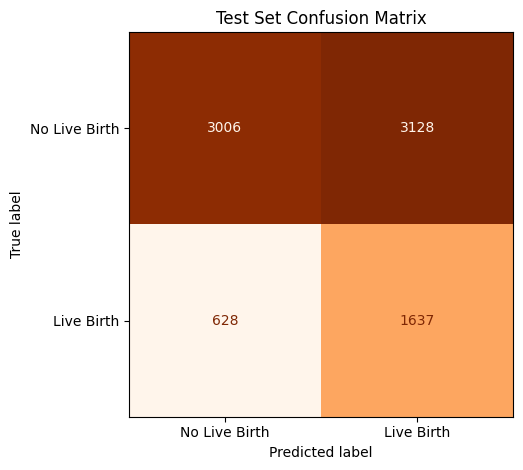

In [37]:
# Simple Logistic Regression with OPTIMAL THRESHOLD
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'max_iter':1000, 'random_state': 42, 'class_weight': 'balanced'}
results_LR = model_pipeline_augmented(X_train, y_train_live_birth, X_test, y_test_live_birth, model, metrics_list, params, 
k=10, stratified=True, AIC=True, smote=False, SHAP=False, optimal_threshold=True)

In [ ]:
with open('probas_C_FA.txt', 'w') as f:
    for item in results['y_test_proba']:
        f.write("%s\n" % item)

# COMPARISON OF ROC AUC

In [42]:
import plotly.graph_objs as go

In [43]:
def read_list_from_file(filename):
    # Try to open and read the file

    with open(filename, 'r') as f:
        list_from_file = f.readlines()

    # Remove newline characters
    list_from_file = [item.strip() for item in list_from_file]

    # Convert strings to floats
    list_from_file = [float(item) for item in list_from_file]

    return list_from_file

In [44]:
LR = read_list_from_file('probas_LR.txt')
SLR = read_list_from_file('probas_LR2.txt')
DT = read_list_from_file('probas_DT.txt')
RF = read_list_from_file('probas_RF.txt')
XGB = read_list_from_file('probas_XGB.txt')
MLP = read_list_from_file('probas_MLP.txt')
C_FA = read_list_from_file('probas_C_FA.txt')
C_DC = read_list_from_file('probas_C_DC_LR.txt')

y_true_CDC = read_list_from_file('truths_C_DC.txt')

In [45]:
auc_dict = {'LR':np.array(LR),
            'SLR':np.array(SLR),
            'DT':np.array(DT),
            'RF':np.array(RF),
            'XGB':np.array(XGB),
            'MLP':np.array(MLP),
            'C_FA':np.array(C_FA),
            'C_DC':np.array(C_DC)}

In [46]:
def plot_auc_curves(model_probs_dict, y_true, y_true_CDC, line_colors):
    """
    Plots AUC ROC curve for different models using Plotly.

    Args:
        model_probs_dict (dict): a dictionary of lists of predicted probabilities associated to their model name as a key
        y_true (list): list of ground truths
        line_colors (list): list of color codes for lines

    Returns:
        Plotly figure
    """
    
    data = []

    y_true = np.array(y_true)
    
    for i, (model_name, y_scores) in enumerate(model_probs_dict.items()):
        # Compute ROC curve and ROC area for each model
        if model_name != 'C_DC':
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc = roc_auc_score(y_true, y_scores)
        else:
            fpr, tpr, _ = roc_curve(y_true_CDC, y_scores)
            roc_auc = roc_auc_score(y_true_CDC, y_scores)
        
        # Create trace for the ROC curve
        trace0 = go.Scatter(
            x=fpr, 
            y=tpr, 
            mode='lines', 
            name=f'{model_name} (AUC = {roc_auc:.3f})',
            line=dict(color=line_colors[i % len(line_colors)])  # Cycle through line colors
        )
        
        # Add trace to the data list
        data.append(trace0)

     # Create the diagonal line
    diagonal_line = go.Scatter(
        x=[0, 1],
        y=[0, 1],
        mode='lines',
        name='Random (AUC = 0.5)',
        line=dict(color='black', dash='dash', width=1)  # Dashed line style
    )

    data.append(diagonal_line)

    # Define layout
    layout = go.Layout(
        title=dict(text='Receiver Operating Characteristic Curve', x=0.5, font=dict(size=22)),  # Centered title
        xaxis=dict(title='False Positive Rate', showgrid=True, gridcolor='lightgrey', range=[0, 1], constrain='domain',  titlefont=dict(size=16)),  # Lighter grid and range from 0 to 1
        yaxis=dict(title='True Positive Rate', showgrid=True, gridcolor='lightgrey', range=[0, 1],  titlefont=dict(size=16)),  # Lighter grid and range from 0 to 1
        showlegend=True,
        font=dict(family='didot'),  # Font family
        paper_bgcolor='white',  # White background
        plot_bgcolor='white',  # White background
        legend=dict(x=0.83, y=0.04, font=dict(size=14)),  # Legend inside plot and smaller font size
        width=1000,  # Width of the plot
        height=800,  # Height of the plot
        #margin=dict(l=1, r=1, b=1, t=100, pad=0)  # Less white space around
    )

    # Create plot
    fig = go.Figure(data=data, layout=layout)

    
    return fig


In [47]:
import plotly.io as pio

In [65]:
#line_colors = ['#2B65EC', '#056608', 'deeppink', '#A74AC7', '#E9AB17', '#E42217', '#FF9249', '#BDAEB6']

line_colors = ['#FF9249', '#6C804B', '#B19933', '#82ADAE', '#7F8F8F', '#FF9BBC', '#979596', '#BDAEB6']

fig = plot_auc_curves(auc_dict, y_test_live_birth, y_true_CDC, line_colors)

In [66]:
fig

In [67]:
pio.write_image(fig, 'ROC.png', width=1000, height=800, scale=4)

# KMEANS INVESTIGATION

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [ ]:
gaia = ['#FF9249', '#302C2E', '#F0E9DE', '#FF9BBC', '#82ADAE', '#6C804B', '#B19933', '#7F8F8F', '#979596', '#BDAEB6']

In [ ]:
def plot_silhouette_manual(X, n_clusters=10, random_state=0, colors=None):
    """
    Plot the silhouette scores of data samples for a given number of clusters.

    This function uses KMeans clustering to label samples in the dataset and then computes and 
    visualizes their silhouette scores. The silhouette score for each sample measures its similarity 
    to its own cluster compared to other clusters, with a higher value indicating better clustering.
    An average silhouette score for all samples is also computed and displayed as a dashed line.

    Args:
        X (numpy.ndarray or pandas.DataFrame): The input samples to cluster and compute silhouette scores.
        n_clusters (int, optional): The number of clusters to form using KMeans. Defaults to 10.
        random_state (int, optional): Determines random number generation for centroid initialization. 
        colors (list of str, optional): Colors for the clusters. If not specified, colors will be chosen 
            automatically. Length of list should be at least as long as `n_clusters`.

    Returns:
        None: The function displays the silhouette plot and saves it as 'silhouette.png'.
    """

    model = KMeans(n_clusters=n_clusters, random_state=random_state)
    cluster_labels = model.fit_predict(X) + 1

    # The silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(X, cluster_labels - 1)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels - 1)

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(12, 8)

    ax.set_xlim([-0.1, 0.8])
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels - 1 == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors[i % len(colors)] if colors is not None else None
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=1.0)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i + 1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title(f"Silhouette Plot", fontsize=18, fontname='Didot')
    ax.set_xlabel("Silhouette coefficient values", fontsize=12, fontname='Didot')
    ax.set_ylabel("Cluster label", fontsize=12, fontname='Didot')

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="black", linestyle="--")

    ax.text(silhouette_avg+0.02, 2.1, 
            "AVG = {:.3f}".format(silhouette_avg), 
            rotation=0, color='black', fontsize=10)

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8])

    for spine in ax.spines.values():
        spine.set_visible(False)

    
    plt.savefig('silhouette.png', dpi=600)
    plt.show()


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


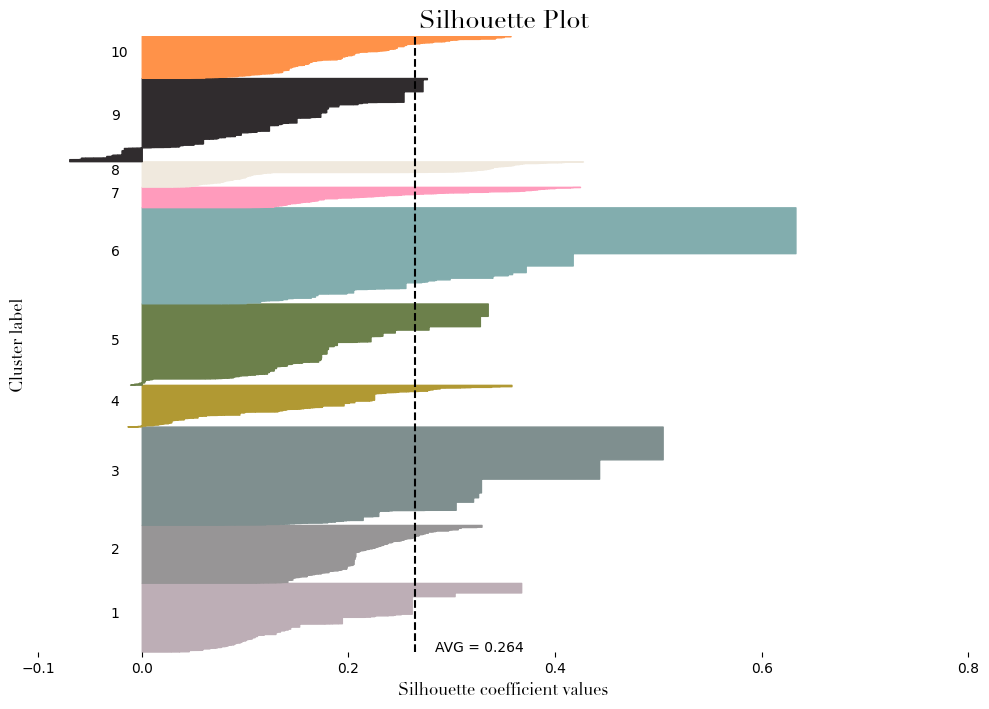

In [ ]:
gaia_reversed = gaia[::-1]

plot_silhouette_manual(X_train, n_clusters=10, random_state=0, colors=gaia_reversed)

#

# BEST MODEL

### C = 0.1

Average optimal threshold = 0.506
AIC: -43775.508
BIC: -43093.316

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.610486,0.344784,0.740533,0.470415,0.646625
Standard Deviation,0.006461,0.004770,0.020020,0.006216,0.008988



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.612346,0.347417,0.733333,0.471473,0.638357


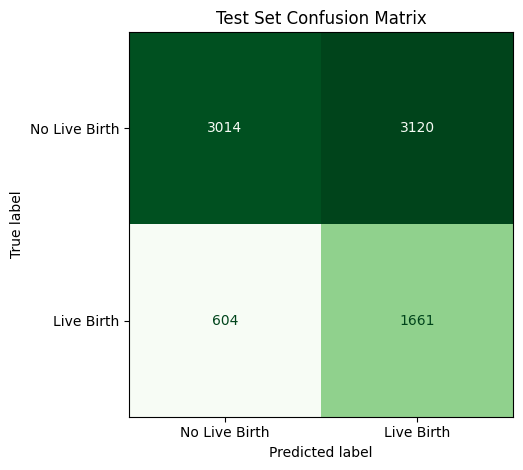


FEATURES ANALYSIS


,feature,importance_mean,importance_std
75,SPERM_FROM SPECIFIC_TREATMENT_TYPE_IVF,0.625670,0.040737
7,STIMULATION_USED,0.602300,0.106583
57,CAUSE_OF_INFERTILITY__MALE_FACTOR SPECIFIC_TRE...,0.438990,0.016803
55,CAUSE_OF_INFERTILITY__MALE_FACTOR SPERM_FROM,0.273421,0.042503
10,SPECIFIC_TREATMENT_TYPE_IVF,0.223702,0.014341
47,CAUSE_OF_INFERTILITY__OVULATORY_DISORDER STIMU...,0.200856,0.019186
6,CAUSE_OF_INFERTILITY__ENDOMETRIOSIS,0.200365,0.042898
60,CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED STIM...,0.194084,0.020004
42,CAUSE__OF_INFERTILITY__TUBAL_DISEASE SPECIFIC_...,0.191610,0.015811
63,CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED SPEC...,0.151403,0.020768


In [34]:
# Squared Logistic Regression with OPTIMAL THRESHOLD
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'max_iter':4000, 'random_state': 42, 'class_weight': 'balanced', 'penalty':'l1', 'solver':'saga', 'C':0.1}
results_C_01 = model_pipeline(X_train_poly, y_train_live_birth, X_test_poly, y_test_live_birth, model, metrics_list, params, 
k=10, stratified=True, AIC=True, smote=False, SHAP=False, optimal_threshold=True, importances=True)

In [36]:
with open('probas_best_baseline.txt', 'w') as f:
    for item in results_C_01['y_test_proba']:
        f.write("%s\n" % item)

In [35]:
results_C_01['feature_importances'].to_csv('my_data.csv', index=True)